Package import and function definitions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib notebook

In [2]:
def generate_house_code(house_code: str) -> np.array: 

    if house_code[0]=='0':
        house_code_array = zero_bit
    elif house_code[0]=='1':
        house_code_array = one_bit
    
    for item in house_code[1:]:
        if item == '0':
            house_code_array = np.concatenate([house_code_array, zero_bit])
        elif item == '1':
            house_code_array = np.concatenate([house_code_array, one_bit])
            
    return house_code_array

Generate list of burst binaries.

In [5]:
burst_list = [file for file in os.listdir() if '.npy' in file]

# Burst Analysis

Select index for associated burst file, load and plot magnitude of IQ data.

In [6]:
idx = 0
complex_data = np.load(burst_list[idx])

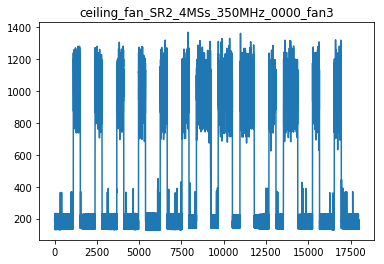

In [7]:
fig, ax = plt.subplots()
ax.plot(np.absolute(complex_data))
plt.title(burst_list[idx].split('.')[0])
plt.show()

From the plot above we see that signal is present for two distinct time periods. Set a threshold on absolute value of IQ data to better visualize the on periods.

In [8]:
threshold = 500
on_idx = np.where(np.absolute(complex_data)>=threshold)[0]
off_idx = np.where(np.absolute(complex_data)<threshold)[0]

b = np.absolute(complex_data)
b[on_idx]=1
b[off_idx]=0

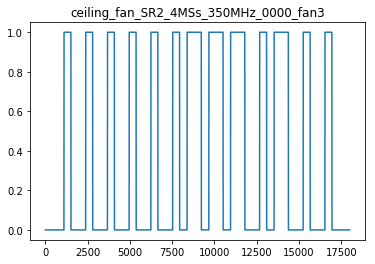

In [9]:
fig, ax = plt.subplots()
ax.plot(b)
plt.title(burst_list[idx].split('.')[0])
plt.show()

A bit represented by $n$ on samples followed by $m$ off samples. Total samples per bit are determined below. 

In [10]:
on_set = np.array(list(set(np.diff(np.where(b==1)[0]))))
off_set = np.array(list(set(np.diff(np.where(b==0)[0]))))

print('Unique on samples: ', on_set)
print('Unique off samples: ', off_set)

Unique on samples:  [  1 874 875 876 877 445 447]
Unique off samples:  [  1 842 843 844 410 412 413 414]


In [11]:
sr = 2.4e6 #samp/s

on_short = int(np.mean(on_set[(on_set > 1) & (on_set<800)]))
on_long = int(np.mean(on_set[(on_set > 1) & (on_set>800)]))

off_short = int(np.mean(off_set[(off_set > 1) & (off_set<800)]))
off_long = int(np.mean(off_set[(off_set > 1) & (off_set>800)]))

tot_samp_0 = on_short+off_long
tot_samp_1 = on_long+off_short

print('Samples for 0 bit value: {}'.format(tot_samp_0))
print('Samples for 1 bit value: {}'.format(tot_samp_1))

samp_per_sym = (tot_samp_0 + tot_samp_1)//2

print('Average samples per bit: {}'.format(samp_per_sym))

Samples for 0 bit value: 1289
Samples for 1 bit value: 1287
Average samples per bit: 1288


In [12]:
sr = 2.4e6 #samp/s

bit_duration = samp_per_sym/sr
zero_on_duration = on_short/sr
zero_off_duration = off_long/sr

one_on_duration = off_short/sr
one_off_duration = on_long/sr

print('Bit duration: {} ms'.format(bit_duration*1e3))

Bit duration: 0.5366666666666666 ms


# Bit Pattern Generation

The cells below can be used to generate random commands given a house code defined by the user. Samples for on/off long/short calculated in the previous analysis cells are hard coded. A message sent by the remote consists of 13 bits forming four unique components.

 1. Preamble: 2 bits, always 00
 - House Code: 4 bits, manually set via DIP switches in remote
 - Couse Code/Command Ceparator: 3 bits, always 111
 - Command: 4 bits, 6 possible commands
 
#### Commands
1. Light Power - 0000
- Light Dimmer - 1000
- Fan Off - 1001
- Fan Speed 1 - 0001
- Fan Speed 2 - 0010
- Fan Speed 3 - 0100

#### Example Bit Pattern
House Code - 1001

Command - Fan Off

Bit Pattern - 0010011111001

In [16]:
# Hard coded sample for on/off short/long.
on_short = 446
on_long = 875
off_short = 412
off_long = 843

zero_bit = np.concatenate([np.ones(on_short),np.zeros(off_long)])
one_bit = np.concatenate([np.ones(on_long),np.zeros(off_short)])

preamble = np.concatenate([np.zeros(500), zero_bit, zero_bit])
house_command_separator = np.concatenate([one_bit, one_bit, one_bit])

command_dict = {
                'light_power':np.concatenate([zero_bit, zero_bit, zero_bit, zero_bit]),
                'light_dimmer':np.concatenate([one_bit, zero_bit, zero_bit, zero_bit]),
                'fan_off':np.concatenate([one_bit, zero_bit, zero_bit, one_bit]),
                'fan_speed_1':np.concatenate([zero_bit, zero_bit, zero_bit, one_bit]),
                'fan_speed_2':np.concatenate([zero_bit, zero_bit, one_bit, zero_bit]),
                'fan_speed_3':np.concatenate([zero_bit, one_bit, zero_bit, zero_bit])
               }

Six ceiling fan/light commands. 

`'light_power', 'light_dimmer', 'fan_off', 'fan_speed_1', 'fan_speed_2', 'fan_speed_3'`

In [36]:
house_code_bits = '1000'
house_code = generate_house_code(house_code_bits)

# Random command generation
command_choice = np.random.choice(list(command_dict.keys()))

bit_pattern = np.concatenate([preamble, house_code, house_command_separator, command_dict[command_choice]])

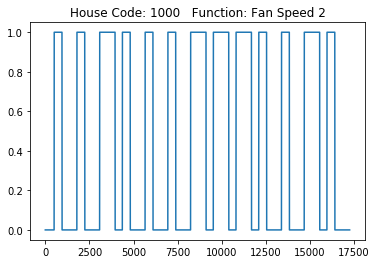

In [37]:
remote_func = command_choice.replace('_', ' ').title()
fig, ax = plt.subplots()
ax.plot(bit_pattern)
plt.title('House Code: {}   Function: {}'.format(house_code_bits, remote_func))
plt.show()